In [4]:
from pynq import allocate
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay

In [39]:
origin_image = Image.open("input.png")

In [40]:
overlay = Overlay("resize_gemm.bit")

In [41]:
overlay?

In [42]:
regs = overlay.resize_accel_0.register_map


In [43]:
regs

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  img_inp_1 = Register(img_inp=write-only),
  img_inp_2 = Register(img_inp=write-only),
  img_out_1 = Register(img_out=write-only),
  img_out_2 = Register(img_out=write-only),
  rows_in = Register(rows_in=write-only),
  cols_in = Register(cols_in=write-only),
  rows_out = Register(rows_out=write-only),
  cols_out = Register(cols_out=write-only)
}

In [54]:
width,height = origin_image.size
new_width = 64
new_height = 64
in_buffer = allocate(shape=(height,width), dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(new_height,new_width), dtype=np.uint8, cacheable=1)
in_buffer[:] = np.array(origin_image)

In [55]:
 # the address of axi-lite registers
REG_ADDRESS_CTRL = 0x00
'''0x00 : Control signals
       bit 0  - ap_start (Read/Write/COH)
       bit 1  - ap_done (Read)
       bit 2  - ap_idle (Read) can be disabled with config_rtl -no_idle
       bit 3  - ap_ready (Read/COR)

       bit 4  - ap_continue (Read/Write/SC) for ap_ctrl_chain protocol
       bit 5  - x
       bit 6  - x
       bit 7  - auto_restart (Read/Write) enabled by config_interface -s_axilite_auto_restart_counter  

       bit 9  - interrupt (Read) Present when there is at least one enabled interrupt 
       others - reserved'''
REG_ADDRESS_GIER = 0x04 # Global Interrupt Enable Register (Read/Write)
'''0x04 : Global Interrupt Enable Register
       bit 0  - Global Interrupt Enable (Read/Write)
       others - reserved'''
REG_ADDRESS_IP_IER = 0x08 # IP Interrupt Enable Register (Read/Write)
'''0x08 : IP Interrupt Enable Register (Read/Write)
       bit 0  - enable ap_done interrupt (Read/Write)
       bit 1  - enable ap_ready interrupt (Read/Write)
       others - reserved'''
REG_ADDRESS_IP_ISR = 0x0C # IP Interrupt Status Register (Read)
'''0x0c : IP Interrupt Status Register (Read/TOW)
       bit 0  - ap_done (COR/TOW)
       bit 1  - ap_ready (COR/TOW)
       others - reserved'''
REG_ADDRESS_IMGIN_L = 0x10
REG_ADDRESS_IMGOUT_L = 0x1C
REG_ADDRESS_ROWS_IN = 0x28 # height / rows
REG_ADDRESS_COLS_IN = 0x30 # width / cols
REG_ADDRESS_ROWS_OUT = 0x38
REG_ADDRESS_COLS_OUT = 0x40

In [56]:
 # Configure the axi-lite register
overlay.resize_accel_0.write(REG_ADDRESS_GIER, 0x01) # bit 0  - Global Interrupt Enable (Read/Write)
overlay.resize_accel_0.write(REG_ADDRESS_IP_IER, 0x01) # bit 0  - enable ap_done interrupt (Read/Write)

overlay.resize_accel_0.write(REG_ADDRESS_IMGIN_L, in_buffer.physical_address)
overlay.resize_accel_0.write(REG_ADDRESS_IMGOUT_L, out_buffer.physical_address)
overlay.resize_accel_0.write(REG_ADDRESS_ROWS_IN, height)
overlay.resize_accel_0.write(REG_ADDRESS_COLS_IN, width)
overlay.resize_accel_0.write(REG_ADDRESS_ROWS_OUT, new_height)
overlay.resize_accel_0.write(REG_ADDRESS_COLS_OUT, new_width)


In [57]:

# start to run
overlay.resize_accel_0.write(REG_ADDRESS_CTRL, 0x01) # start

In [58]:
overlay.resize_accel_0.register_map.CTRL.AP_DONE

1

In [59]:
out_buffer

PynqBuffer([[206, 206, 209, ..., 247, 247, 247],
            [207, 207, 207, ..., 247, 247, 247],
            [207, 211, 219, ..., 247, 247, 247],
            ...,
            [173, 160, 163, ..., 124, 118, 111],
            [164, 167, 169, ..., 124, 122, 110],
            [164, 168, 166, ...,  98, 118, 122]], dtype=uint8)

In [60]:
resized_image = Image.fromarray(out_buffer)

Image size: 64x64 pixels.


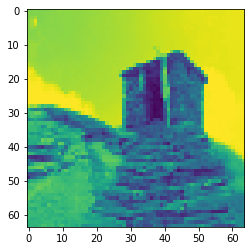

In [61]:


print("Image size: {}x{} pixels.".format(new_width, new_height))
plt.imshow(resized_image)

